In [15]:
# importing libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [2]:
# 1) loading dataset
df = pd.read_csv("../datasets/weatherww2/SummaryofWeather.csv", parse_dates=["Date"])
df = df[["STA", "Date", "MaxTemp", "MinTemp", "MeanTemp"]]

/home/mveronesi/.conda/envs/dslab/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (7,8,18,25) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


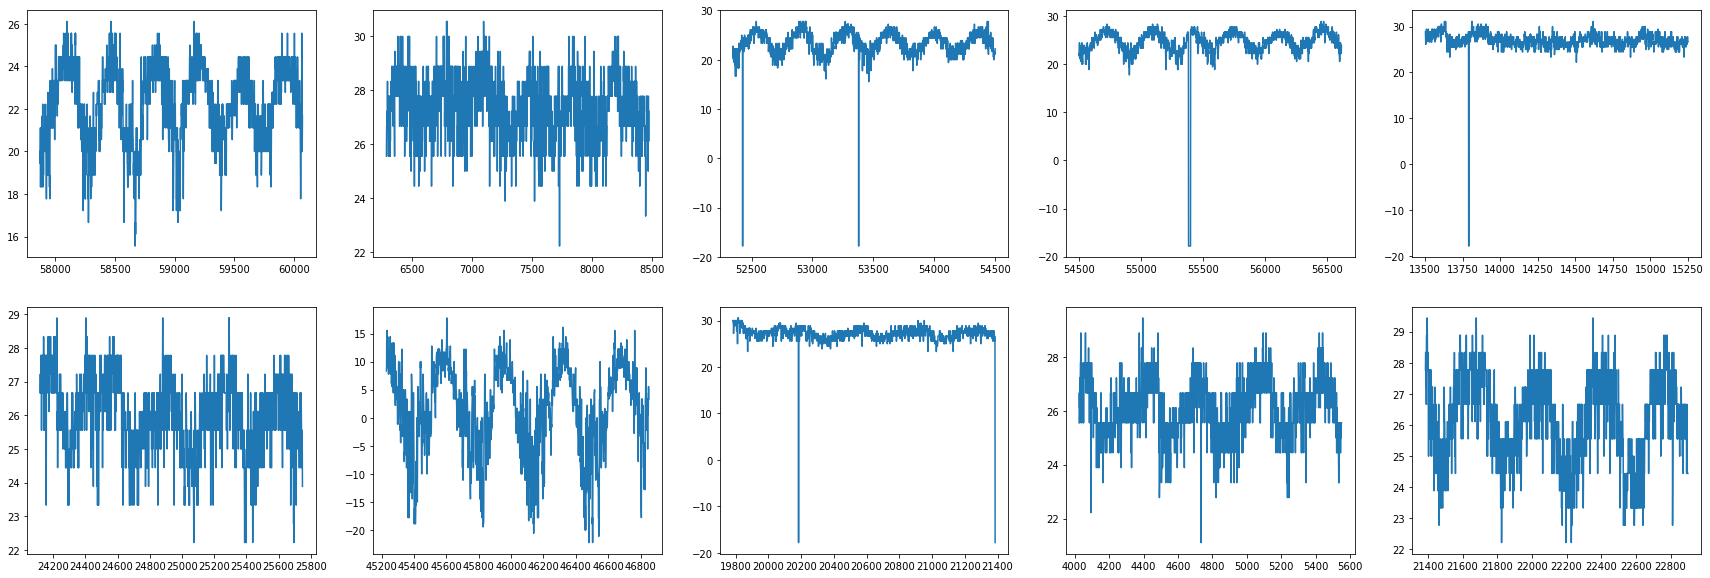

In [3]:
# 2) top 10 most complete sensors distribution
STA = df.groupby("STA")["Date"].count()
STA.sort_values(inplace=True, ascending=False)
top10 = (STA[:10].index).values # take first 10 STA
fig, ax = plt.subplots(2, 5, figsize=(30, 10))
for i in range(len(top10)):
    st_index = top10[i]
    values = df.loc[df["STA"] == st_index]
    ax[int(i/5), i%5].plot(values.index.values, values["MeanTemp"].values)

<AxesSubplot:xlabel='Date'>

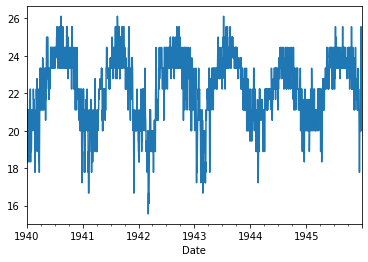

In [4]:
# 3) and 4): select measures of station 22508 and plotting the time serie
best_STA = df.loc[df["STA"] == 22508, ["Date", "MeanTemp"]]
best_STA = best_STA.set_index("Date").squeeze()
best_STA.plot()

In [5]:
# counting nan values and contiguity of dates
nan_val = best_STA.isna().sum() # True is 1
if nan_val > 0:
    print("WARNING: found ", nan_val, " NaN values")
else:
    print("OK: No NaN values found")
dates = best_STA.index.values
contiguos = True
for i in range(len(dates)-1):
    diff = dates[i+1] - dates[i]
    if diff != np.timedelta64(1, "D"):
        print("WARNING: found not contiguos dates")
        contiguos = False
        break
if contiguos == True:
    print("OK: All dates are contiguos")

OK: No NaN values found
OK: All dates are contiguos


In [23]:
WINDOW_SIZE = 5 # hyperparameter
N_WINDOWS = best_STA.size - WINDOW_SIZE - 1 # total number of windows
windows_df = np.zeros((N_WINDOWS, WINDOW_SIZE+1), dtype=float) # the (W+1)th columns is for predictions
# generating dataframe array
for i in range(N_WINDOWS):
    for j in range(WINDOW_SIZE+1):
        # i is the starting point for the current window
        windows_df[i, j] = best_STA[i + j]
X = windows_df[:, :WINDOW_SIZE]
y = windows_df[:, WINDOW_SIZE]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, shuffle=False)

SCORES
R^2:  0.6790214844395752
MAE:  0.6380210137084023
MSE:  0.69617021657811


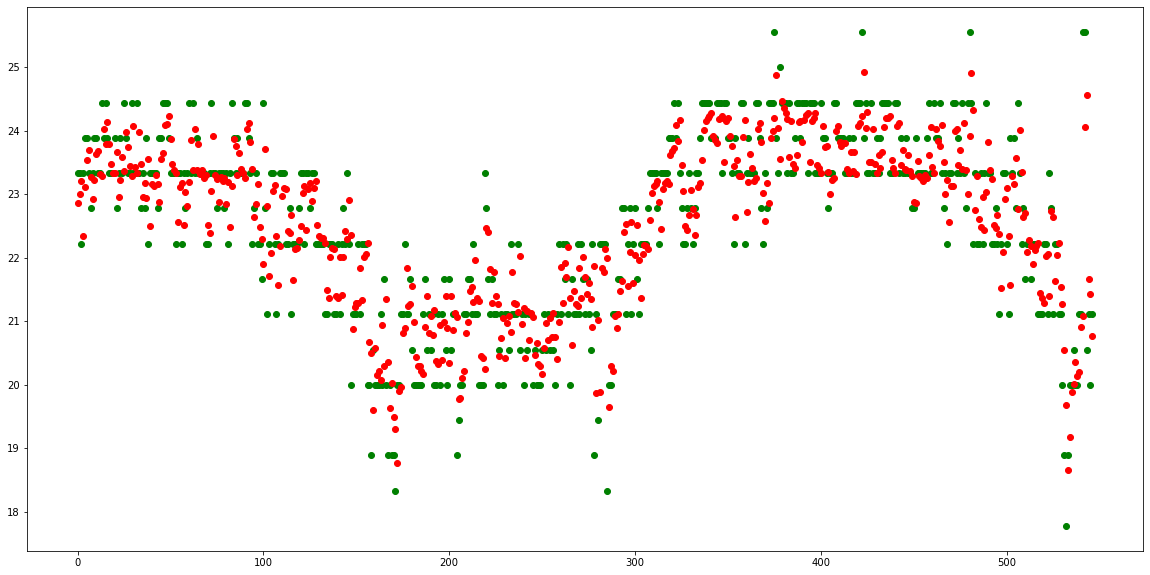

In [28]:
#reg = make_pipeline(PolynomialFeatures(5), Lasso(alpha=0.5))
reg = LinearRegression()
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
print("SCORES")
R2 = r2_score(y_test, y_pred)
print("R^2: ", R2)
MAE = mean_absolute_error(y_test, y_pred)
print("MAE: ", MAE)
MSE = mean_squared_error(y_test, y_pred)
print("MSE: ", MSE)
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
ax.scatter(np.arange(len(y_test)), y_test, c="green")
ax.scatter(np.arange(len(y_pred)), y_pred, c="red")